This project aims to explore the relationship between NFL team's performance and their stadium's attendance .The final plot represents every team's relationship between attendance and performance. To obtain the data in one data frame several merges have been done as well as other data cleaning techniques such as string detection and manipulation. The plot evidences there is not a strong relationship between how well/bad a team is performing and its rise/decline in attendance. The initial hypothesis is that if last season a team did not perform well the expectations for next season will be low and they will not attend. This relationship is not clear in the plot. In fact the biggest changes in attendance from a season to another are due to team's relocation (St Louis Rams to Los Angeles for instance).
In the code there is another visualization in which you can select the team and compere its progressions of both the attendance and winning percentage from 2000-2019. From that visualization we can see how bad performance can coincide with low attendance. However, the relationship is not exact, nor linear nor present for all the teams.

Sources:
https://www.kaggle.com/datasets/sujaykapadnis/nfl-stadium-attendance-dataset/data?select=standings.csv

https://www.kaggle.com/datasets/sujaykapadnis/nfl-stadium-attendance-dataset/data?select=games.csv

https://www.kaggle.com/datasets/sujaykapadnis/nfl-stadium-attendance-dataset/data?select=attendance.csv


In [1]:
%matplotlib widget
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

sns.set_style("darkgrid")

In [13]:
# Load and clean attendance data frames
attendance = pd.read_csv("attendance.csv")
attendance.head()
attendance.groupby(["team", "year"]).count()
attendance.dtypes
attendance = attendance[["year", "week", "team_name", "weekly_attendance"]]
attendance.head()


,year,week,team_name,weekly_attendance
0,2000,1,Cardinals,77434.0
1,2000,2,Cardinals,66009.0
2,2000,3,Cardinals,NaN
3,2000,4,Cardinals,71801.0
4,2000,5,Cardinals,66985.0


In [14]:
# Load and clean games data frame
games = pd.read_csv("games.csv")
games.head()
games.sort_values(["home_team", "year"], ascending=True).head()
print(len(np.sort(games["away_team_name"].unique())))
np.sort(attendance["team_name"].unique()) == np.sort(games["away_team_name"].unique())
games = games[["year","week", "home_team_name", "away_team_name", "winner"]]
borrar = games[games["week"].str.contains(pat="[a-zA-Z]", regex=True)].index
games.drop(borrar, axis=0, inplace=True)
games["week"] = games["week"].astype("int64")
games.dtypes
len(games["winner"].unique())
games.head()


32


,year,week,home_team_name,away_team_name,winner
0,2000,1,Vikings,Bears,Minnesota Vikings
1,2000,1,Chiefs,Colts,Indianapolis Colts
2,2000,1,Redskins,Panthers,Washington Redskins
3,2000,1,Falcons,49ers,Atlanta Falcons
4,2000,1,Steelers,Ravens,Baltimore Ravens


In [5]:
# this function allows us to distinct the team's name and city
def split(cadena):
    a = cadena.split()
    if len(a) == 2:
        return a[-1]
    else:
        return str(a[-2]) + " " + str(a[-1])

In [16]:
dff = pd.merge(left=games, right=attendance, left_on=["year", "week", "home_team_name"], right_on=["year", "week", "team_name"], how="left")
dff["home_team_name"] == dff["winner"]
dff["winner"] = dff["winner"].apply(lambda x: split(x))
dff["winner"].unique()
replacements = {"England Patriots":"Patriots","York Jets":"Jets", "York Giants": "Giants",
                "City Chiefs": "Chiefs", "Angeles Chargers":"Chargers", "Angeles Rams": "Rams",
                 "Bay Packers": "Packers", "Orleans Saints": "Saints","Bay Buccaneers": "Buccaneers",
                 "Francisco 49ers": "49ers", "Diego Chargers": "Chargers", "Louis Rams": "Rams"}

dff["winner"].replace(replacements, inplace=True)
dff["winner"].unique()
dff["Local win"] = dff["home_team_name"] == dff["winner"]
dff.head()
grouped = dff.groupby(["home_team_name", "year"]).agg({"weekly_attendance": "mean", "Local win": "sum"})
grouped.reset_index(inplace= True)
grouped.head()

,home_team_name,year,weekly_attendance,Local win
0,49ers,2000,67745.500,4
1,49ers,2001,67469.500,7
2,49ers,2002,67699.125,5
3,49ers,2003,67580.500,6
4,49ers,2004,64783.875,1


In [17]:
# Load and clean standings data frame
standings = pd.read_csv("standings.csv")
standings = standings[["team_name", "year", "wins", "loss"]]
standings.head()

,team_name,year,wins,loss
0,Dolphins,2000,11,5
1,Colts,2000,10,6
2,Jets,2000,9,7
3,Bills,2000,8,8
4,Patriots,2000,5,11


In [18]:
# merge the data frames
defi = pd.merge(left=grouped, right=standings, how="inner", left_on=["year", "home_team_name"], right_on=["year", "team_name"])
defi["win_pct"] = defi["wins"] / 16
defi.head()


,home_team_name,year,weekly_attendance,Local win,team_name,wins,loss,win_pct
0,49ers,2000,67745.500,4,49ers,6,10,0.3750
1,49ers,2001,67469.500,7,49ers,12,4,0.7500
2,49ers,2002,67699.125,5,49ers,10,6,0.6250
3,49ers,2003,67580.500,6,49ers,7,9,0.4375
4,49ers,2004,64783.875,1,49ers,2,14,0.1250


In [19]:
# add each team's division to the data frame
divisions = {"49ers": "NFC West", "Seahawks": "NFC West", "Rams": "NFC West", "Cardinals": "NFC West",
             "Giants" : "NFC East", "Eagles": "NFC East", "Cowboys": "NFC East", "Redskins": "NFC East",
             "Packers": "NFC North", "Vikings": "NFC North", "Lions": "NFC North", "Bears": "NFC North",
             "Saints": "NFC South", "Panthers": "NFC South", "Buccaneers": "NFC South", "Falcons": "NFC South",
              "Patriots": "AFC East", "Dolphins": "AFC East", "Bills": "AFC East", "Jets": "AFC East",
               "Ravens": "AFC North", "Browns": "AFC North", "Steelers": "AFC North", "Bengals": "AFC North",
               "Jaguars": "AFC South", "Texans": "AFC South", "Titans": "AFC South", "Colts": "AFC South",
               "Chiefs": "AFC West", "Chargers": "AFC West", "Raiders": "AFC West", "Broncos": "AFC West"}

any(defi["home_team_name"].map(divisions).isna())
defi["Division"] = defi["home_team_name"].map(divisions)
defi
defi.set_index("year", inplace = True)
defi.head()

,home_team_name,weekly_attendance,Local win,team_name,wins,loss,win_pct,Division
year,,,,,,,,
2000,49ers,67745.500,4,49ers,6,10,0.3750,NFC West
2001,49ers,67469.500,7,49ers,12,4,0.7500,NFC West
2002,49ers,67699.125,5,49ers,10,6,0.6250,NFC West
2003,49ers,67580.500,6,49ers,7,9,0.4375,NFC West
2004,49ers,64783.875,1,49ers,2,14,0.1250,NFC West


In [10]:
opciones = list(defi["Division"].unique())
opciones = ["NFC West","NFC East", "NFC South", "NFC North", "AFC West", "AFC East", "AFC South", "AFC North"]

In [12]:
# This cell allows to select and plot a divison's team attendance across the years
sns.set_theme("talk")
@interact(division=widgets.SelectMultiple(
    options=opciones,
    value=(opciones[0],),
    description='Division'))
def plotear (division):
    plt.clf()
    plt.figure(figsize=(10,6))
    plt.title(str(division[0]))
    
    
    for key, table in defi[defi["Division"] == str(division[0])].groupby("team_name"):
        
        plt.plot(table["weekly_attendance"], label = key)
    
    plt.legend()
    plt.xticks(defi.index.unique()[::3])
    plt.xlabel("Year")
    plt.ylabel("Mean attendance")
    x = plt.gca().xaxis
    for item in x.get_ticklabels():
        item.set_rotation(45)
    plt.show()



interactive(children=(SelectMultiple(description='Division', index=(0,), options=('NFC West', 'NFC East', 'NFC…

In [21]:
equipos = list(defi["home_team_name"].unique())


In [28]:
# This cell allows to select and plot a team's performance and mean attendance across the years
@interact(team=widgets.SelectMultiple(
    options=equipos,
    value=(equipos[0],),
    description='Team'))
def plotear_equipo(team):
    plt.clf()
    fig, ax = plt.subplots(1,2, tight_layout = False, figsize = (10,4))

    for key, table in defi[defi["home_team_name"] == str(team[0])].groupby("team_name"):
        ax[0].plot(table["weekly_attendance"], label = key)
        ax[0].set_ylabel("Mean attendance")
        ax[1].set_ylabel("Win %")
        ax[1].plot(table["win_pct"], label = key)
    plt.legend()
    plt.show()
    

interactive(children=(SelectMultiple(description='Team', index=(0,), options=('49ers', 'Bears', 'Bengals', 'Bi…

C:\Users\dpgdg\AppData\Local\Temp\ipykernel_13612\2502338927.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  correlation = defi.groupby("home_team_name")["weekly_attendance", "win_pct"].corr()


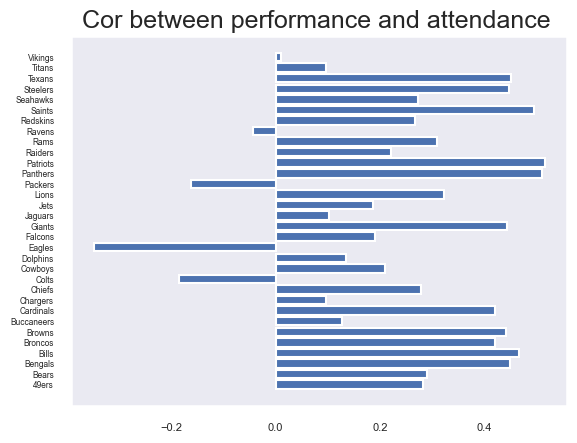

In [ ]:
correlation = defi.groupby("home_team_name")["weekly_attendance", "win_pct"].corr()
correlation.replace(1,0, inplace=True)
final_cor =correlation["weekly_attendance"].drop(correlation[correlation["weekly_attendance"] == 0].index)
final_cor2 = correlation["win_pct"].drop(correlation[correlation["win_pct"] == 0].index)
final_cor.index.droplevel(1)
final_cor.index = final_cor.index.droplevel(1)
plt.barh(y = final_cor.index, width= final_cor.values)
plt.grid(visible=False)
plt.tick_params(axis = "y", labelsize = 6)
plt.tick_params(axis = "x", labelsize = 8)
plt.title("Cor between performance and attendance ")
plt.savefig("project.png")



In [ ]:
final_df = defi[["home_team_name","weekly_attendance", "win_pct", "Division"]]
final_df["win_pct_diff"] = final_df.groupby("home_team_name")["win_pct"].transform("diff")*100
final_df["weekly_attendance_change"] = final_df.groupby("home_team_name")["weekly_attendance"].transform("pct_change")*100
final_df

C:\Users\dpgdg\AppData\Local\Temp\ipykernel_13612\2725172826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["win_pct_diff"] = final_df.groupby("home_team_name")["win_pct"].transform("diff")*100
C:\Users\dpgdg\AppData\Local\Temp\ipykernel_13612\2725172826.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["weekly_attendance_change"] = final_df.groupby("home_team_name")["weekly_attendance"].transform("pct_change")*100


,home_team_name,weekly_attendance,win_pct,Division,win_pct_diff,weekly_attendance_change
year,,,,,,
2000,49ers,67745.500,0.3750,NFC West,NaN,NaN
2001,49ers,67469.500,0.7500,NFC West,37.50,-0.407407
2002,49ers,67699.125,0.6250,NFC West,-12.50,0.340339
2003,49ers,67580.500,0.4375,NFC West,-18.75,-0.175224
2004,49ers,64783.875,0.1250,NFC West,-31.25,-4.138213
...,...,...,...,...,...,...
2015,Vikings,52430.000,0.6875,NFC North,25.00,0.367068
2016,Vikings,66786.125,0.5000,NFC North,-18.75,27.381509
2017,Vikings,66721.125,0.8125,NFC North,31.25,-0.097326


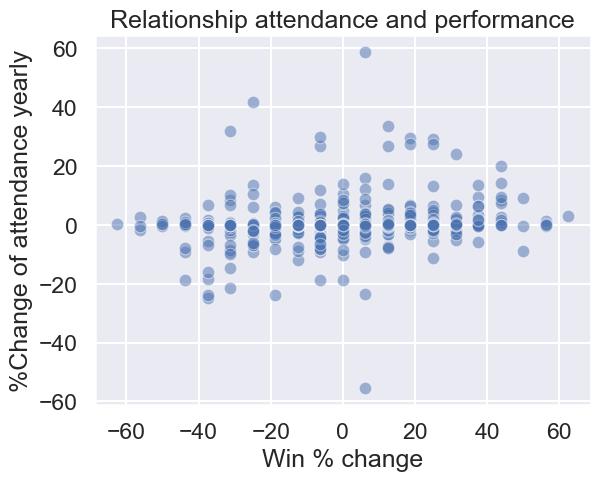

In [ ]:
sns.scatterplot(x = final_df["win_pct_diff"].shift(1), y = final_df["weekly_attendance_change"], alpha = 0.5)
plt.ylabel("%Change of attendance yearly")
plt.xlabel("Win % change")
plt.title("Relationship attendance and performance")
plt.savefig("project2.png")